<a href="https://colab.research.google.com/github/kovzanok/dls-final-task/blob/main/Final_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Установка зависимостей

In [1]:
!pip install insightface onnxruntime

In [2]:
from torch import nn
from insightface.app import FaceAnalysis
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.utils as vutils
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
import cv2
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow

import random
import os
import math

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Подготовка данных

##Архив изображений

Посмотрим результат работы пайплайна на 3 фотографиях: 2 - МакЭвоя и 1 - Скалы. По итогу сравним расстояния между полученными эмбеддингами

In [4]:
!gdown 1T6P8iX3H6Zb-xwAKciFEAfA-xG1BWV3P

Downloading...
From: https://drive.google.com/uc?id=1T6P8iX3H6Zb-xwAKciFEAfA-xG1BWV3P
To: /content/final_dataset.zip
100% 126k/126k [00:00<00:00, 90.3MB/s]


In [5]:
!unzip -q /content/final_dataset.zip -d /content/

replace /content/final_dataset/mcavoy1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
def get_filenames_os(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

In [7]:
filenames = get_filenames_os('/content/final_dataset')

#Пайплайн

##Детекция лиц

Готовая модель для детекции, получаем массив, каждый элемент которого словарь: `{
        'image_path': путь к изображению,
        'faces': массив ббоксов
    }`

In [8]:
app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))


image_folder = "/content/final_dataset"
image_paths = [os.path.join(image_folder, fname) for fname in filenames]


all_faces = []

for path in tqdm(image_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = app.get(img)
    all_faces.append({
        'image_path': path,
        'faces': faces
    })

/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


  0%|          | 0/3 [00:00<?, ?it/s]

Выведем исходные изображения и результат детекции

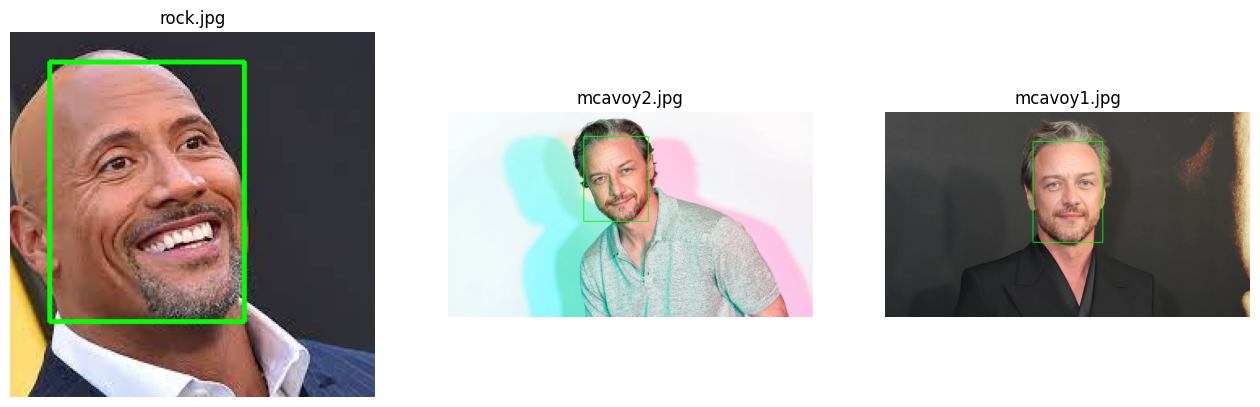

In [9]:
fig = plt.figure(figsize=(16, 16))

for i, idx in enumerate(range(len(all_faces))):
    img = cv2.imread(all_faces[idx]['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    for face in all_faces[idx]['faces']:
        x1, y1, x2, y2 = map(int, face.bbox)
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

        fig.add_subplot(1, 3, i+1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(os.path.basename(all_faces[idx]['image_path']))

plt.show()

Обрежем изображения по ббоксам и сохраним в отдельной папке для следующего шага

In [10]:
save_dir = "/content/cropped_faces"
os.makedirs(save_dir, exist_ok=True)

for entry in all_faces:
    image_path = entry['image_path']
    filename = os.path.basename(image_path)

    img = cv2.imread(image_path)

    face = entry['faces'][0]
    x1, y1, x2, y2 = map(int, face.bbox)

    h, w = img.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    face_crop = img[y1:y2, x1:x2]

    save_path = os.path.join(save_dir, filename)
    cv2.imwrite(save_path, face_crop)


##Определение ключевых точек

Структура SHG взята с 1 задания, с гугл диска скачиваем уже обученные веса модели

###HourglassNet

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

In [12]:
class HourglassBlock(nn.Module):
    def __init__(self, channels, depth):
        super().__init__()
        self.depth = depth

        self.res = ResidualBlock(channels, channels)

        if depth > 1:
            self.next = HourglassBlock(channels, depth - 1)
        else:
            self.center = ResidualBlock(channels, channels)


        self.downsample = nn.MaxPool2d(kernel_size=2,stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        skip = self.res(x)
        x = self.downsample(skip)

        if self.depth > 1:
            x = self.next(x)
        else:
            x = self.center(x)

        x = self.upsample(x)
        return x + skip

In [13]:
class HourglassNet(nn.Module):
    def __init__(self, channels=128, depth=4):
        super().__init__()
        self.initial_conv = nn.Conv2d(3, channels, kernel_size=7, stride=1, padding=3)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

        self.hg1 = HourglassBlock(channels,depth)
        self.hg2 = HourglassBlock(channels,depth)
        self.hg3 = HourglassBlock(channels,depth)

        self.merge1 = nn.Conv2d(5, channels, kernel_size=1)
        self.merge2 = nn.Conv2d(5, channels, kernel_size=1)

        self.head1 = nn.Sequential(
            nn.Conv2d(channels, 5, kernel_size=3, padding=1),
            nn.BatchNorm2d(5)
        )
        self.head2 = nn.Sequential(
            nn.Conv2d(channels, 5, kernel_size=3, padding=1),
            nn.BatchNorm2d(5)
        )
        self.head3 = nn.Sequential(
            nn.Conv2d(channels, 5, kernel_size=3, padding=1),
            nn.BatchNorm2d(5)
        )

        self.conv1 = nn.Conv2d(channels, channels, 1)
        self.conv2 = nn.Conv2d(channels, channels, 1)
        self.conv3 = nn.Conv2d(channels, channels, 1)


    def forward(self, x):
        x = self.initial_conv(x)
        x = self.relu(self.bn(x))
        skip1 = self.hg1(x)
        res1 = self.head1(self.conv1(skip1))
        inter1 = skip1 + self.merge1(res1)
        skip2 = self.hg2(inter1)
        res2 = self.head2(self.conv2(skip2))
        inter2 = skip2 + self.merge2(res2)
        x = self.hg3(inter2)
        res3 = self.head3(self.conv3(x))
        return [res1, res2, res3]



In [14]:
!gdown 1qCzxrZos9ZzmWE_zwZKT5kEnCSUK8n3f

Downloading...
From: https://drive.google.com/uc?id=1qCzxrZos9ZzmWE_zwZKT5kEnCSUK8n3f
To: /content/best_model_keypoints.pth
100% 3.75M/3.75M [00:00<00:00, 225MB/s]


In [15]:
model = HourglassNet().to(device)
model.load_state_dict(torch.load('/content/best_model_keypoints.pth', weights_only=True, map_location=device))

<All keys matched successfully>

###Датасет

In [16]:
class NamedDataset(Dataset):
    def __init__(self, img_dir, img_names, transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = img_names

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

###Функции

Функция выравнивания отличается от той, что была в задании 1, поскольку там датасет был уже выровнен и доп выравнивание очень портило изображения. В финальном пайплайне все иначе

In [17]:
def align_face(image, keypoints, output_size=(120, 120)):
    template = np.array([
        [38.2946, 51.6963],   # левый глаз
        [73.5318, 51.5014],   # правый глаз
        [56.0252, 71.7366],   # нос
        [41.5493, 92.3655],   # левый угол рта
        [70.7299, 92.2041]    # правый угол рта
    ], dtype=np.float32)

    # Центрируем шаблон под нужный размер
    template[:, 0] += (output_size[0] - 112) / 2
    template[:, 1] += (output_size[1] - 112) / 2

    keypoints = np.array(keypoints, dtype=np.float32)
    M, _ = cv2.estimateAffine2D(keypoints, template, method=cv2.RANSAC)

    aligned_face = cv2.warpAffine(
        image, M, output_size, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )

    return aligned_face


In [18]:
def heatmap_to_coords(hm):
    coords = []
    for i in range(hm.shape[0]):
        y, x = torch.nonzero(hm[i] == hm[i].max(), as_tuple=True)
        if len(x) > 0 and len(y) > 0:
            coords.append((x[0].item(), y[0].item()))
        else:
            coords.append((0, 0))
    return coords

###Выравнивание

Берутся фото из папки cropped_faces, прогоняются через модель и на выходе имеем координаты ключевых точек. Отобразим их на изображении, а также выведем результат выравнивания

In [19]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

named_dataset = NamedDataset(
    img_dir='/content/cropped_faces',
    transform=transform,
    img_names = filenames
)

loader = DataLoader(named_dataset)

save_dir = "/content/aligned_faces"
os.makedirs(save_dir, exist_ok=True)

@torch.no_grad()
def transform_images(loader, model):
    total_res = []

    fig, axes = plt.subplots(2, 3, figsize=(5 * 3, 5))

    for i, (image, name) in enumerate(tqdm(loader, leave=False)):
        model.eval()
        image = image.to(device)
        outputs = model(image)
        pred_heatmaps = outputs[-1]
        img = image[0]
        img_vis = TF.to_pil_image(torch.clamp((img + 1) / 2, 0, 1))
        pred = pred_heatmaps[0]
        pred_coords = heatmap_to_coords(pred)

        img_pil = TF.to_pil_image(torch.clamp((img + 1) / 2, 0, 1))
        img_np = np.array(img_pil)


        ax = axes[0][i]
        ax.imshow(img_vis)
        ax.set_title(name[0])
        ax.scatter([x for x, y in pred_coords], [y for x, y in pred_coords], c='red', marker='x', label='Pred', s=20)
        ax.axis('off')

        aligned_image = torch.tensor(align_face(img_np, pred_coords))
        aligned_image = aligned_image.float() / 255.0

        ax = axes[1][i]
        ax.imshow(aligned_image)
        ax.axis('off')

        file_path = os.path.join(save_dir, name[0])
        vutils.save_image(aligned_image.permute(2,0,1),file_path)


Результат выглядит достаточно крипово, но задача с выравниваем выполнена, если качество выравнивания вызывает сомнения, то они будут развеяны на момента сравнения расстояний между эмбеддингами

  0%|          | 0/3 [00:00<?, ?it/s]

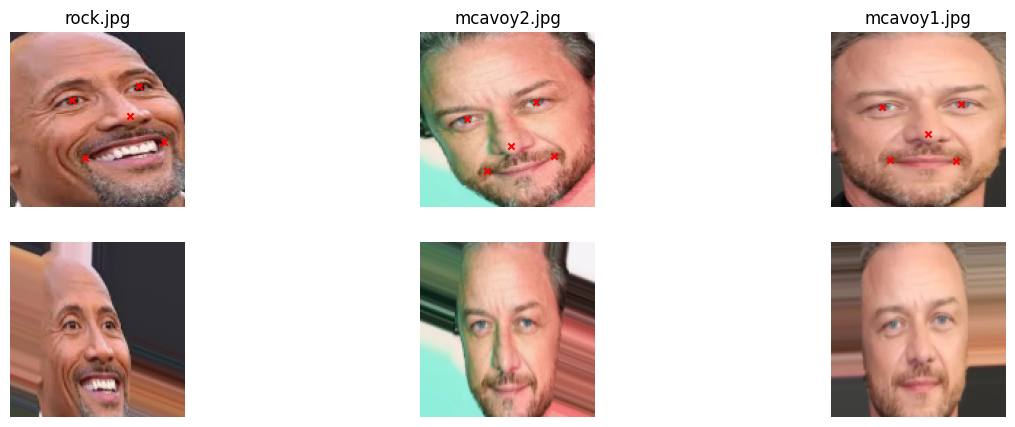

In [20]:
transform_images(loader, model)

##Распознавание

Качаем веса для модели и инициализируем ее

In [21]:
!gdown 1LipAZuw6EGYa071EQN9BUrkh7Q-z2RUq

Downloading...
From (original): https://drive.google.com/uc?id=1LipAZuw6EGYa071EQN9BUrkh7Q-z2RUq
From (redirected): https://drive.google.com/uc?id=1LipAZuw6EGYa071EQN9BUrkh7Q-z2RUq&confirm=t&uuid=b8f53594-34bc-4947-bb06-a79cbf8238bd
To: /content/best_recognition_model_triplet.pth
100% 45.1M/45.1M [00:00<00:00, 213MB/s]


In [22]:
embedding_dim = 128
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, embedding_dim)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
model.load_state_dict(torch.load('/content/best_recognition_model_triplet.pth',weights_only=True, map_location=device)['model'])

<All keys matched successfully>

In [24]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, img_names, transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = img_names

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [25]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

dataset = ImageDataset(
    img_dir="/content/aligned_faces",
    transform=transform,
    img_names = filenames
)

loader = DataLoader(dataset, batch_size=len(filenames))

In [26]:
for images in tqdm(loader, leave=False):
    images = images.to(device)
    embeddings = model(images)

  0%|          | 0/1 [00:00<?, ?it/s]

Получаем тензор с 3 эмбеддингами и теперь сравним расстояния между ними, для фотографий Скалы и МакЭвоя оно должно быть ощутимо больше, чем для двух фото МакЭвоя

In [27]:
from numpy import dot
from numpy.linalg import norm

embeddings = embeddings.detach().numpy()

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)


def cosine_distance(a, b):
    return 1 - dot(a, b) / (norm(a) * norm(b))


for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        euc = euclidean_distance(embeddings[i], embeddings[j])
        cos = cosine_distance(embeddings[i], embeddings[j])
        print(f"Dist between {filenames[i]} and {filenames[j]}: Euclidean={euc:.4f}, Cosine={cos:.4f}")


Dist between rock.jpg and mcavoy2.jpg: Euclidean=211.0152, Cosine=1.6914
Dist between rock.jpg and mcavoy1.jpg: Euclidean=245.0935, Cosine=1.8606
Dist between mcavoy2.jpg and mcavoy1.jpg: Euclidean=120.9495, Cosine=0.7116


Результат внушительный, разница практически в 2 раза для обоих расстояний